## Data Preparation

In [6]:
!pip install pygris

import pygris
from pygris import tracts
# import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd

!pip install folium
import folium

Using FIPS code '09' for input 'CT'


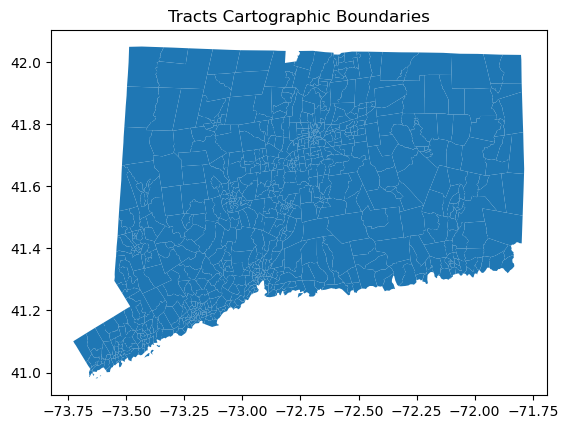

In [7]:
# Download geometry
ct_tracts = tracts(state = "CT", cb = True, cache = True, year = 2016)

# Display geometry
fig, ax = plt.subplots()
ct_tracts.plot(ax = ax)
plt.title("Tracts Cartographic Boundaries");

In [8]:
# Import tracts population data
pop = pd.read_csv("../data/population.csv")

In [9]:
# Convert data type so join key matches
ct_tracts["Geo_TRACT"] = ct_tracts["TRACTCE"].astype(int)

In [10]:
# Join attributes to geometry
tracts = ct_tracts.merge(pop, how = "inner", on='Geo_TRACT')

In [11]:
?gpd.to_crs("EPSG:4326")

Object `gpd.to_crs("EPSG:4326")` not found.


In [12]:
# Project tracts
tracts = tracts.to_crs("EPSG:2234")

# Calculate area
tracts["Area"] = tracts.area

# Calculate population density
tracts["PopDensity"] = tracts["SE_A00001_001"]/tracts["Area"]


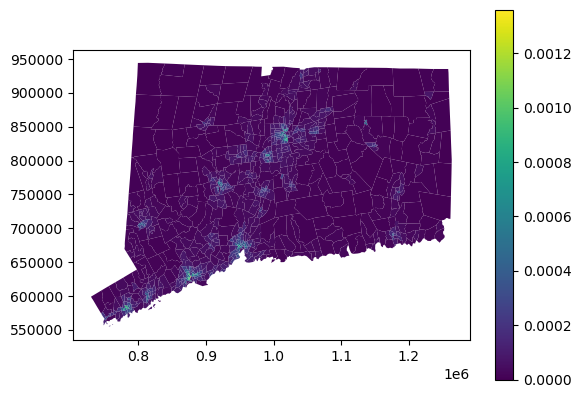

In [13]:
tracts.plot("PopDensity", legend = True);

In [31]:
tracts

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,Geo_PCI,Geo_TAZ,Geo_UGA,Geo_BTTR,Geo_BTBG,Geo_PUMA5,Geo_PUMA1,SE_A00001_001,Area,PopDensity
0,09,001,011000,1400000US09001011000,09001011000,110,CT,4473567,3841130,"POLYGON ((768806.438 564631.131, 773167.739 56...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5496,6.578389e+07,0.000084
1,09,001,020800,1400000US09001020800,09001020800,208,CT,2315472,0,"POLYGON ((779750.763 593331.028, 780102.614 59...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2831,2.494969e+07,0.000113
2,09,001,021400,1400000US09001021400,09001021400,214,CT,1640443,0,"POLYGON ((774314.477 583462.508, 776262.618 58...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6956,1.769721e+07,0.000393
3,09,001,022200,1400000US09001022200,09001022200,222,CT,1442382,117063,"POLYGON ((780699.029 578728.334, 781267.249 57...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4468,1.667225e+07,0.000268
4,09,001,043100,1400000US09001043100,09001043100,431,CT,6652660,58522,"POLYGON ((801316.652 604980.220, 803589.804 60...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4894,7.210574e+07,0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,09,007,610300,1400000US09007610300,09007610300,6103,CT,16389995,222770,"POLYGON ((1055056.154 680079.089, 1059941.959 ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4179,1.789226e+08,0.000023
829,09,009,120200,1400000US09009120200,09009120200,1202,CT,6878579,542471,"POLYGON ((897298.354 686860.960, 898586.789 68...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6566,8.004847e+07,0.000082
830,09,005,310300,1400000US09005310300,09005310300,3103,CT,970203,0,"POLYGON ((897220.702 850485.688, 898674.905 85...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1416,1.036246e+07,0.000137
831,09,009,141600,1400000US09009141600,09009141600,1416,CT,1067640,0,"POLYGON ((947690.753 677347.410, 947450.392 67...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4962,1.152112e+07,0.000431


In [1]:
!pip install rasterio
import rasterio

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
raster_path = '../data/ct_2016_ccap_hires_landcover_20200915.tif'
landcover = rasterio.open(raster_path)
arr = landcover.read(1)
affine=landcover.transform

In [15]:
!pip install rasterstats

from rasterstats import zonal_stats

# Transform to a difference CRS.
zone = tracts.to_crs(landcover.crs)
stats = zonal_stats(zone, arr, affine=affine)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.0 MB/s eta 0:00:00


/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [26]:
df = pd.DataFrame(stats)
df

,min,max,mean,count
0,2.0,21.0,10.746680,6111530
1,2.0,20.0,6.367183,2317904
2,2.0,20.0,3.986602,1644135
3,2.0,21.0,5.371539,1548918
4,2.0,22.0,7.237290,6698858
...,...,...,...,...
828,2.0,22.0,10.200328,16622550
829,2.0,22.0,8.788187,7436780
830,2.0,21.0,4.817850,962686
831,2.0,20.0,3.959455,1070358


In [27]:
df_new = zonal_stats(zone, arr, affine=affine, categorical = True)

In [35]:
df_categorical = pd.DataFrame(df_new)
df_categorical

,2,5,8,11,12,13,14,15,17,18,19,20,21,22,7,6,0,23
0,1577751.0,1144459.0,23775.0,1180392.0,71818.0,12375.0,1586.0,17531.0,132.0,136572.0,423692.0,142589.0,1378858.0,NaN,NaN,NaN,NaN,NaN
1,809638.0,618991.0,1726.0,846657.0,9915.0,3038.0,NaN,NaN,NaN,NaN,NaN,27939.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1127059.0,252242.0,4375.0,231148.0,15583.0,NaN,NaN,NaN,NaN,NaN,NaN,13728.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1034456.0,216203.0,557.0,91714.0,5287.0,NaN,NaN,NaN,NaN,NaN,20584.0,80161.0,99956.0,NaN,NaN,NaN,NaN,NaN
4,1891481.0,1518050.0,69397.0,2951298.0,59342.0,111854.0,3868.0,14487.0,NaN,NaN,NaN,9940.0,68655.0,486.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,1374277.0,1383902.0,98495.0,11922975.0,160184.0,1003114.0,56206.0,86055.0,NaN,NaN,6618.0,74707.0,296965.0,129120.0,29932.0,NaN,NaN,NaN
829,1822336.0,1031744.0,214670.0,3334055.0,116629.0,19559.0,4997.0,32995.0,NaN,NaN,14223.0,104771.0,594172.0,5431.0,131818.0,9380.0,NaN,NaN
830,533143.0,241203.0,8139.0,141081.0,6149.0,NaN,NaN,1677.0,NaN,NaN,NaN,7344.0,23950.0,NaN,NaN,NaN,NaN,NaN
831,719097.0,191291.0,NaN,148415.0,2535.0,NaN,NaN,NaN,NaN,NaN,NaN,9020.0,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_categorical['max_type'] = pd.cut(df_categorical.idxmax(axis=1))

TypeError: cut() missing 1 required positional argument: 'bins'

In [39]:
combined_df = pd.concat([tracts, df_categorical], axis=1)
combined_df

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,18,19,20,21,22,7,6,0,23,max_type
0,09,001,011000,1400000US09001011000,09001011000,110,CT,4473567,3841130,"POLYGON ((768806.438 564631.131, 773167.739 56...",...,136572.0,423692.0,142589.0,1378858.0,NaN,NaN,NaN,NaN,NaN,2
1,09,001,020800,1400000US09001020800,09001020800,208,CT,2315472,0,"POLYGON ((779750.763 593331.028, 780102.614 59...",...,NaN,NaN,27939.0,NaN,NaN,NaN,NaN,NaN,NaN,11
2,09,001,021400,1400000US09001021400,09001021400,214,CT,1640443,0,"POLYGON ((774314.477 583462.508, 776262.618 58...",...,NaN,NaN,13728.0,NaN,NaN,NaN,NaN,NaN,NaN,2
3,09,001,022200,1400000US09001022200,09001022200,222,CT,1442382,117063,"POLYGON ((780699.029 578728.334, 781267.249 57...",...,NaN,20584.0,80161.0,99956.0,NaN,NaN,NaN,NaN,NaN,2
4,09,001,043100,1400000US09001043100,09001043100,431,CT,6652660,58522,"POLYGON ((801316.652 604980.220, 803589.804 60...",...,NaN,NaN,9940.0,68655.0,486.0,NaN,NaN,NaN,NaN,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,09,007,610300,1400000US09007610300,09007610300,6103,CT,16389995,222770,"POLYGON ((1055056.154 680079.089, 1059941.959 ...",...,NaN,6618.0,74707.0,296965.0,129120.0,29932.0,NaN,NaN,NaN,11
829,09,009,120200,1400000US09009120200,09009120200,1202,CT,6878579,542471,"POLYGON ((897298.354 686860.960, 898586.789 68...",...,NaN,14223.0,104771.0,594172.0,5431.0,131818.0,9380.0,NaN,NaN,11
830,09,005,310300,1400000US09005310300,09005310300,3103,CT,970203,0,"POLYGON ((897220.702 850485.688, 898674.905 85...",...,NaN,NaN,7344.0,23950.0,NaN,NaN,NaN,NaN,NaN,2
831,09,009,141600,1400000US09009141600,09009141600,1416,CT,1067640,0,"POLYGON ((947690.753 677347.410, 947450.392 67...",...,NaN,NaN,9020.0,NaN,NaN,NaN,NaN,NaN,NaN,2


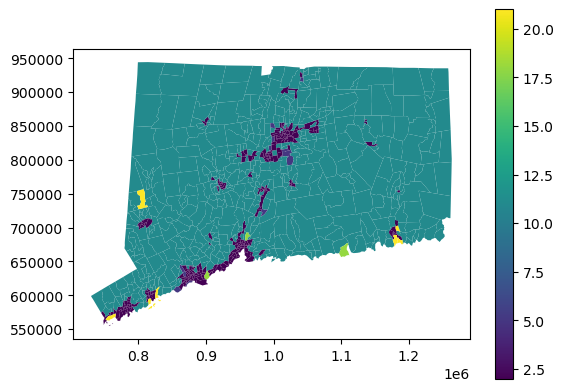

In [40]:
combined_df.plot("max_type", legend = True);

In [42]:
combined_df.to_csv('combined_data.csv', index=False)